In [15]:
import sys

sys.path.append('../..')

import torch
import pytorch_lightning as pl
from pytorch_lightning.utilities.model_summary import ModelSummary

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pickle
import random
from tqdm import tqdm
from scipy.signal import resample

from pycochleagram.utils import play_array
from IPython.display import Audio

In [2]:
class AudioAutoEncoder(pl.LightningModule):
    def __init__(self, input_size=12000):
        super().__init__()
        self.bottle_neck_dim = 256
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 2*input_size//3),
            nn.ReLU(), 
            nn.Linear(2*input_size//3, input_size//3), 
            nn.ReLU(), 
            nn.Linear(input_size//3, self.bottle_neck_dim), 
            nn.ReLU())
        
        self.decoder = nn.Sequential(
            nn.Linear(self.bottle_neck_dim, input_size//3), 
            nn.ReLU(), 
            nn.Linear(input_size//3, 2*input_size//3), 
            nn.ReLU(), 
            nn.Linear(2*input_size//3, input_size))
        
    def forward(self, wav):
        encoding = self.encoder(wav)
        reconstructed = self.decoder(encoding)
        return reconstructed
        
    def get_encoding(self, wav):
        return self.encoder(wav)

    def get_reconstructed(self, emb):
        return self.decoder(emb)
    
    def training_step(self, batch, batch_idx):
        out = self(batch)
        loss = nn.MSELoss()(out, batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        out = self(batch)
        loss = nn.MSELoss()(out, batch)
        self.log('val_loss',  loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 1e-3)
        return optimizer 

In [3]:
class AudioDataset(Dataset):
    def __init__(self, root: str, sr: int=12000):
        self.root = root
        self.files = glob.glob(os.path.join(self.root, '*.pkl'))
        self.sr = sr
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        with open(self.files[idx], 'rb') as f:
            wav = pickle.load(f)

        while wav.shape[0] == 0:
            with open(random.choice(self.files), 'rb') as f:
                wav = pickle.load(f)

        downsampled = resample(wav, self.sr)
        downsampled = downsampled / np.max(np.abs(downsampled))

        return torch.tensor(downsampled, dtype=torch.float32)

In [4]:
trainDataset = AudioDataset('../../../../audio_data/train/', sr=12000)
valDataset = AudioDataset('../../../../audio_data/test/', sr=12000)

In [5]:
BATCH_SIZE = 4
NUM_WORKERS = 4

In [6]:
trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=False)
# trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
# valDataLoader = DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

torch.Size([4, 12000]) torch.float32


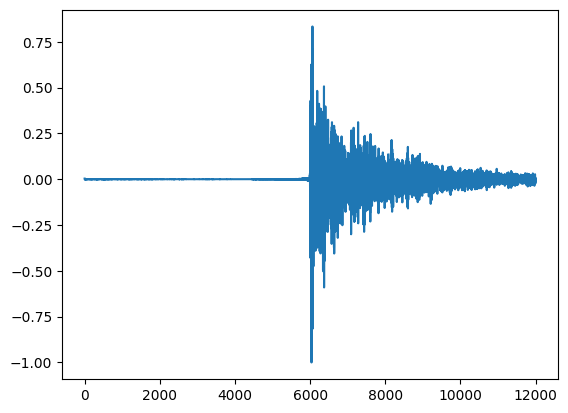

In [7]:
wavs = next(iter(trainDataLoader))
print(wavs.shape, wavs.dtype)
wav = wavs[0].detach().numpy()
plt.plot(wav)
plt.show()

In [8]:
file_name = sorted(glob.glob('./model_weights/*.ckpt'))[1]
print(file_name)
model = AudioAutoEncoder.load_from_checkpoint(file_name, input_size=12000)
ModelSummary(model)

./model_weights/audioautoencoder-model-epoch=98-val_loss=0.00.ckpt


  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 129 M 
1 | decoder | Sequential | 129 M 
---------------------------------------
258 M     Trainable params
0         Non-trainable params
258 M     Total params
1,032.337 Total estimated model params size (MB)

In [9]:
logger = pl.loggers.TensorBoardLogger('tb_logs', name='audio_autoencoder')
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    dirpath="model_weights",
    filename="audioautoencoder-model-{epoch:02d}-{val_loss:.2f}",
)
trainer = pl.Trainer(accelerator='gpu', devices=1,
                     max_epochs=100, logger=logger,
                     callbacks=[checkpoint_callback])
torch.set_float32_matmul_precision('medium')

/home2/arihanth.srikar/miniconda3/envs/torch/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home2/arihanth.srikar/miniconda3/envs/torch/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
# trainer.fit(model, trainDataLoader, valDataLoader)

# trainer.save_checkpoint('model_weights/final-autoencoder-model.ckpt')

In [19]:
wavs = next(iter(trainDataLoader))
wavs_pred = model(wavs)

In [20]:
wavs_pred = wavs_pred.detach().cpu()

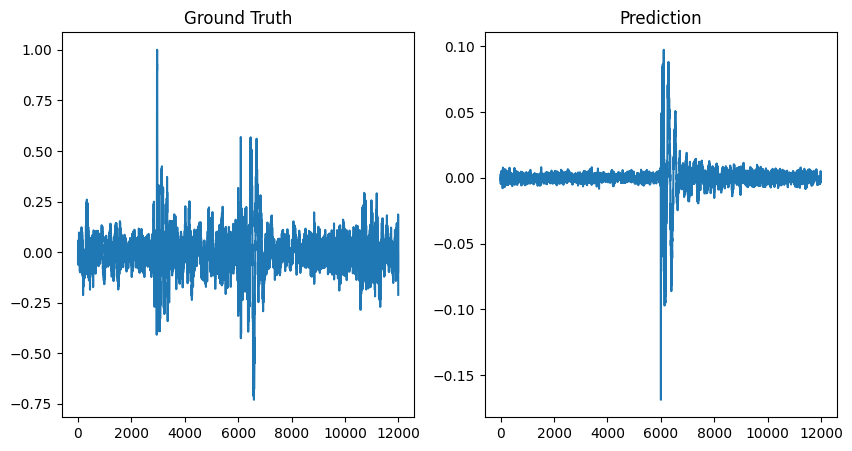

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].set_title('Ground Truth')
axs[0].plot(wavs[0].detach().cpu())
axs[1].set_title('Prediction')
axs[1].plot(wavs_pred[0])
plt.show()

In [22]:
Audio(wavs[0].detach().cpu(), rate=wavs[0].detach().cpu().shape[0])

In [23]:
Audio(wavs_pred[0], rate=wavs_pred[0].shape[0])